In [52]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from multiprocessing import cpu_count

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import warnings

from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import TimeSeriesSplit

# --- Setup logging ---

logging.basicConfig(level=logging.INFO, format='%(message)s')
logger = logging.getLogger()

# --- Define file paths ---
base_paths = [Path("data"), Path(".")]
filename = "Aufgabe_2_CAE.xlsx"
sheet_train = "Trainingsdaten"
sheet_test = "Testdaten"

# --- Load Excel sheets ---
def load_excel_data(paths, file, sheet):
    for path in paths:
        full_path = path / file
        if full_path.exists():
            logger.info(f"Loading '{sheet}' from: {full_path}")
            return pd.read_excel(full_path, sheet_name=sheet)
    raise FileNotFoundError(f"Could not locate '{file}' in any of the specified paths.")

# --- Load datasets ---
df_train = load_excel_data(base_paths, filename, sheet_train)
df_test = load_excel_data(base_paths, filename, sheet_test)

# --- Sanity checks ---
assert not df_train.empty, "Training data is empty!"
assert not df_test.empty, "Test data is empty!"

# --- Display info ---
logger.info(f"\nTraining Data Dimensions: {df_train.shape[0]} rows × {df_train.shape[1]} columns")
logger.info(f"Test Data Dimensions:     {df_test.shape[0]} rows × {df_test.shape[1]} columns\n")
logger.info("Preview of Training Data (last 5 rows):")
logger.info(df_train.tail().to_string(index=False))

Loading 'Trainingsdaten' from: Aufgabe_2_CAE.xlsx
Loading 'Testdaten' from: Aufgabe_2_CAE.xlsx

Training Data Dimensions: 2901 rows × 4 columns
Test Data Dimensions:     671 rows × 4 columns

Preview of Training Data (last 5 rows):
 Zeit in s  Stromdichte in A/m^2  Eintrittstemperatur Zelle in °C  Zelltemperatur in °C
    289600                  5515                        70.227719             85.520703
    289700                  5515                        70.227719             85.511869
    289800                  5515                        70.227719             85.504101
    289900                  5515                        70.227719             85.497274
    290000                  5515                        78.007436             85.491274


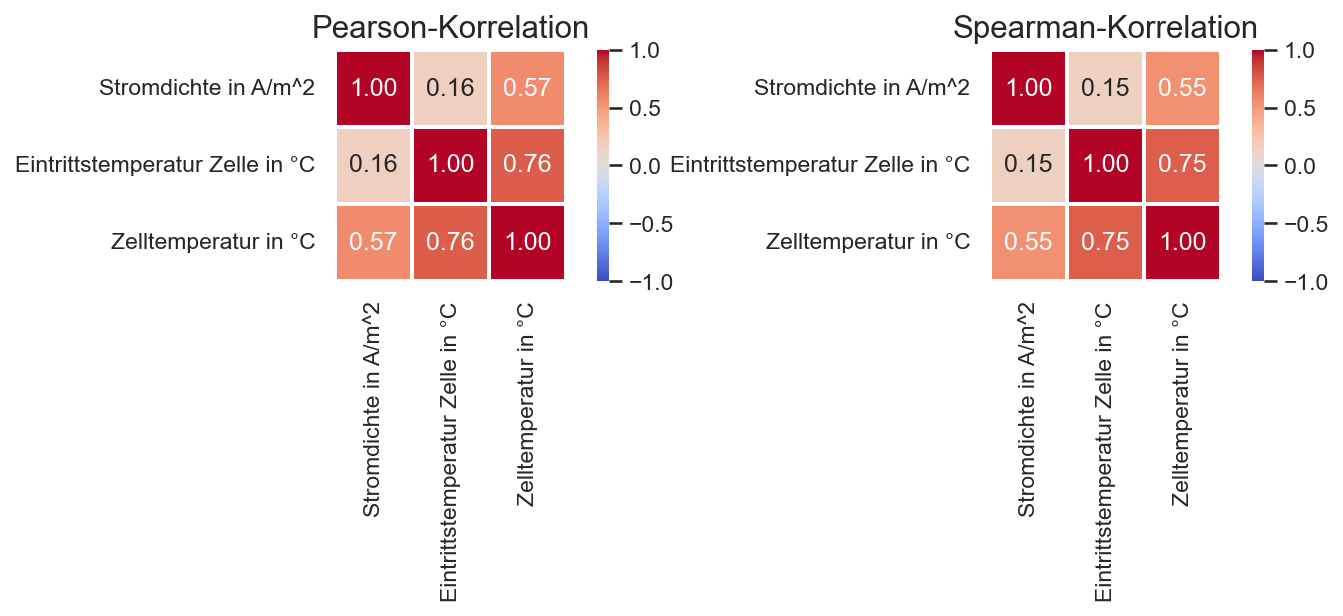

<Figure size 4500x4500 with 0 Axes>

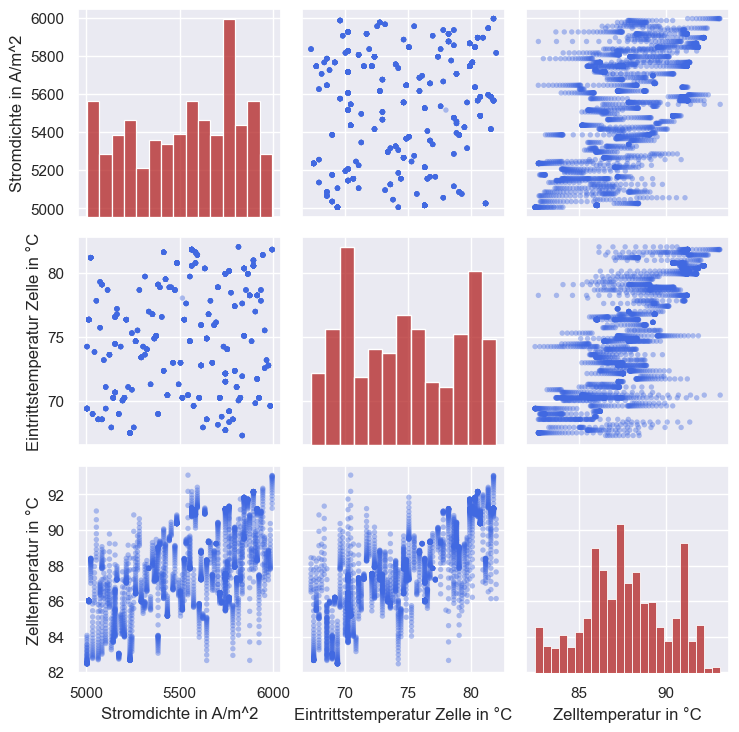

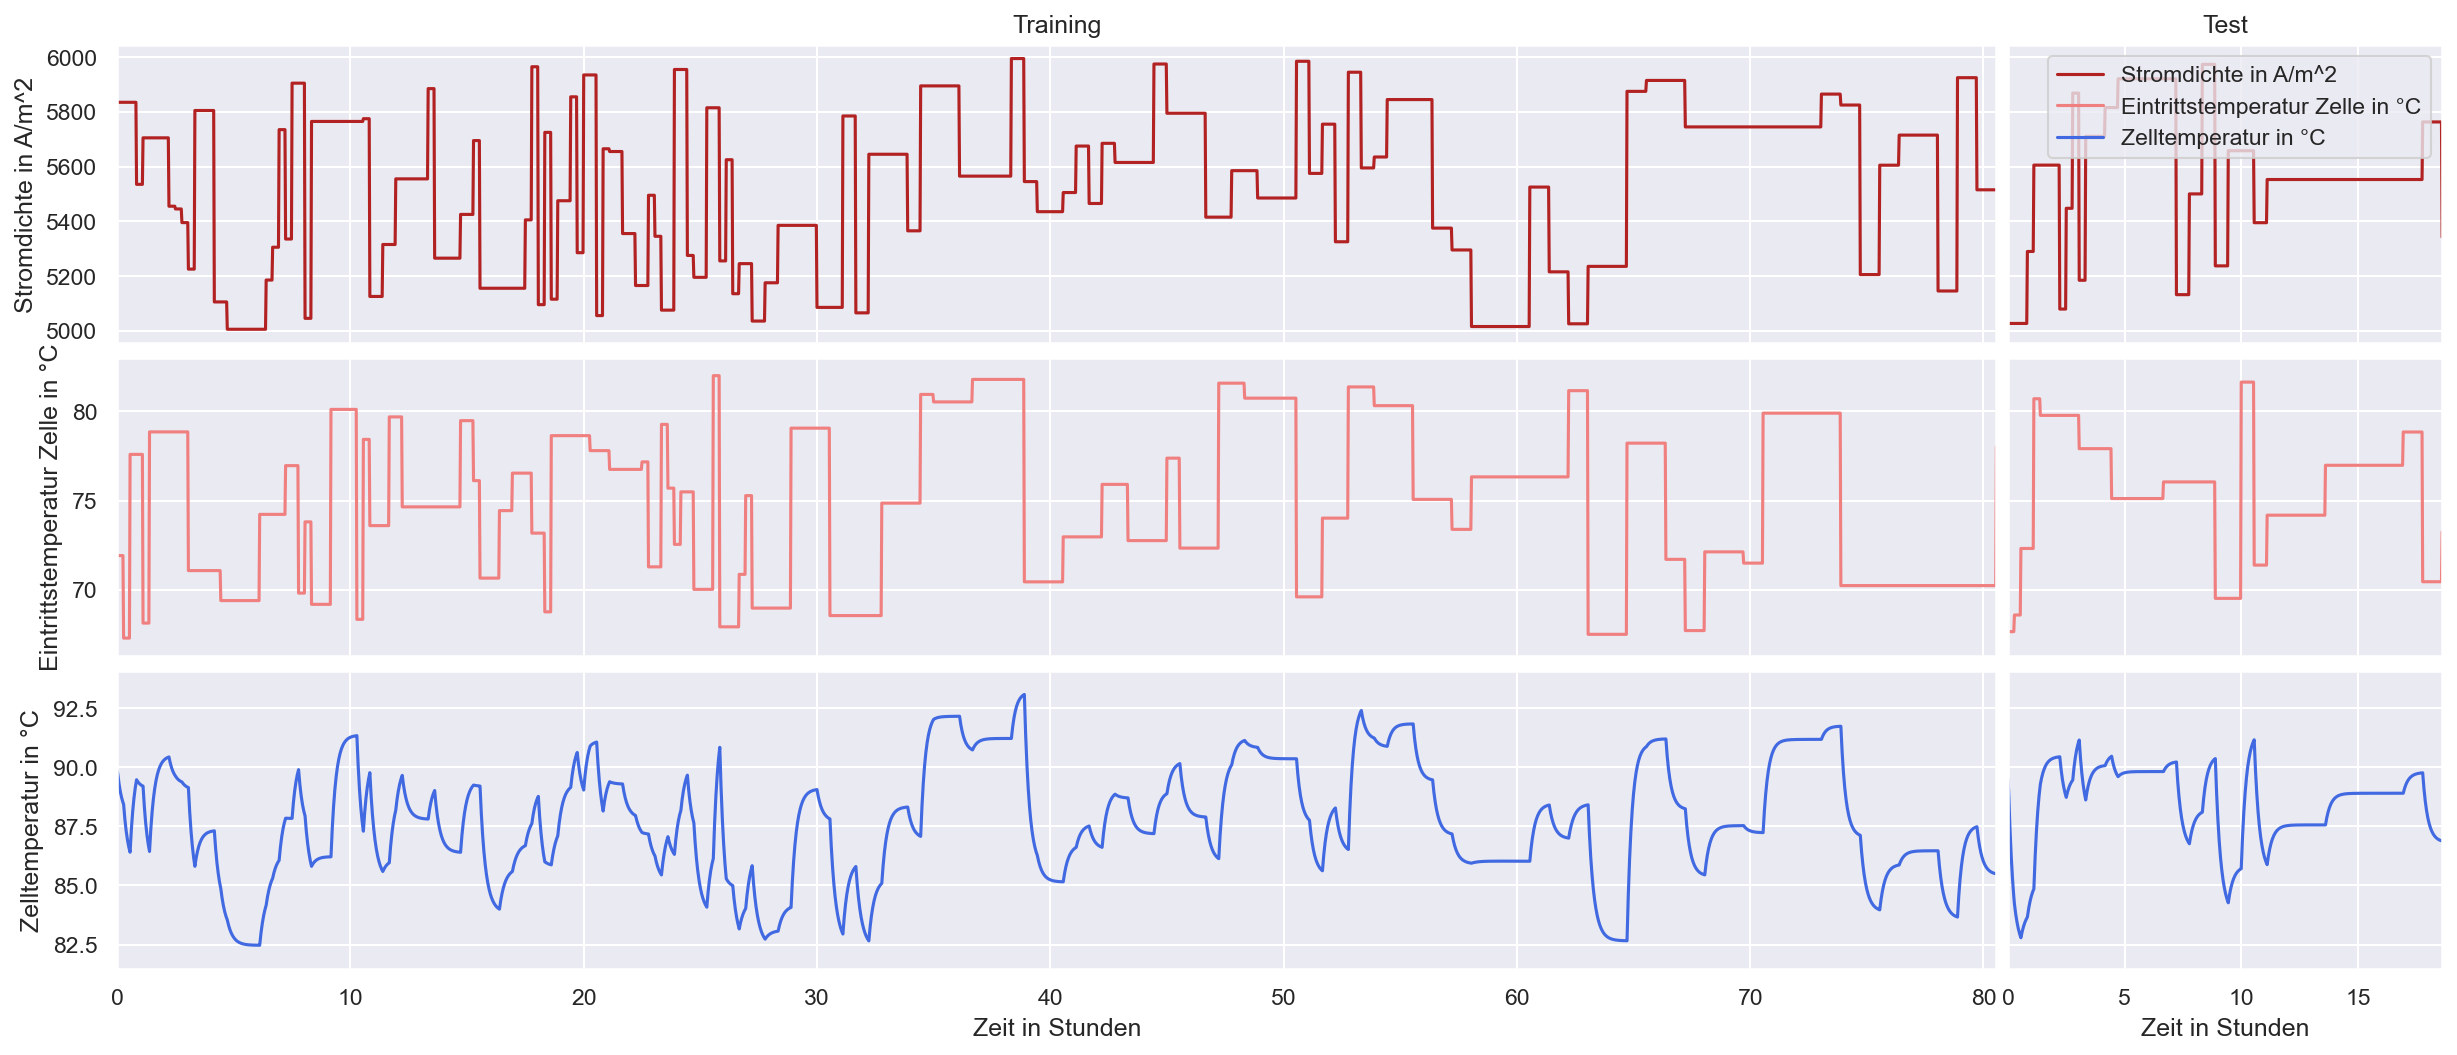

In [53]:
# --- Correlation heatmaps with consistent 'coolwarm' ---
r_pearson = df_train.drop(columns=df_train.columns[0]).corr(method='pearson')
r_spearman = df_train.drop(columns=df_train.columns[0]).corr(method='spearman')

fig1, ax = plt.subplots(1, 2, figsize=(11,2), dpi=150)
fig1.subplots_adjust(wspace=0.05, hspace=0.25)

sns.heatmap(r_pearson, ax=ax[0], linewidth=1, annot=True, cmap="coolwarm",
            vmin=-1, vmax=1, square=True, fmt="0.2f")
ax[0].set_title("Pearson-Korrelation", fontsize=15)

sns.heatmap(r_spearman, ax=ax[1], linewidth=1, annot=True, cmap="coolwarm",
            vmin=-1, vmax=1, square=True, fmt="0.2f")
ax[1].set_title("Spearman-Korrelation", fontsize=15)


# --- PairGrid with 'coolwarm' colors ---
fig2 = plt.figure(figsize=(30,30), dpi=150)
sns.set(style="darkgrid")

feature_cols = [col for col in df_train.columns if col != df_train.columns[0]]
data_for_pairs = df_train[feature_cols]

g = sns.PairGrid(data_for_pairs, despine=False)
g.figure.subplots_adjust(wspace=0.1, hspace=0.1)
g.map_diag(sns.histplot, color="firebrick")         # red-ish for hist
g.map_offdiag(sns.scatterplot, s=15, edgecolor="none",
              alpha=0.4, color="royalblue")         # blue-ish for scatter


# --- Time series plots with 'coolwarm' palette ---
datasets = [df_train, df_test]
titles = ['Training', 'Test']
time_col = 'Zeit in s'
data_cols = ['Stromdichte in A/m^2', 'Eintrittstemperatur Zelle in °C', 'Zelltemperatur in °C']

width_ratio = df_test[time_col].max() / df_train[time_col].max()
fig1, ax = plt.subplots(3, 2, figsize=(20,8), dpi=150,
                        gridspec_kw={'width_ratios': [1, width_ratio]})
fig1.subplots_adjust(wspace=0.01, hspace=0.05)

# Use consistent colors for 'coolwarm' style
colors_coolwarm = ["firebrick", "lightcoral", "royalblue"]  # red -> blue gradient
color_map = dict(zip(data_cols, colors_coolwarm))

for row, col_name in enumerate(data_cols):
    for dataset_idx, (dataset, title) in enumerate(zip(datasets, titles)):
        time_hours = dataset[time_col].div(3600)
        ax[row, dataset_idx].plot(time_hours, dataset[col_name],
                                  color=color_map[col_name], linewidth=1.5)
        
        # Set titles only for first row
        if row == 0:
            ax[row, dataset_idx].set_title(title)
        
        # Set y-label only for training data (left column)
        if dataset_idx == 0:
            ax[row, dataset_idx].set_ylabel(col_name)
        
        # Calculate y-limits
        all_data = pd.concat([df_train[col_name], df_test[col_name]], ignore_index=True)
        padding = 50 if 'Stromdichte' in col_name else 1
        y_min, y_max = all_data.min() - padding, all_data.max() + padding
        ax[row, dataset_idx].set_ylim([y_min, y_max])
        
        # Set x-limits
        ax[row, dataset_idx].set_xlim([time_hours.min(), time_hours.max()])
        
        # Handle x-axis labels
        if row < 2:
            ax[row, dataset_idx].get_xaxis().set_ticklabels([])
        else:
            ax[row, dataset_idx].set_xlabel('Zeit in Stunden')
        
        # Remove y-axis labels from test data
        if dataset_idx == 1:
            ax[row, dataset_idx].get_yaxis().set_ticklabels([])

# Add legend to top-right subplot
for col_name in data_cols:
    ax[0,1].plot([], [], color=color_map[col_name], label=col_name)
ax[0,1].legend(loc='upper right')

In [54]:
rnd_state = 1

# Alternative z-transformation approach using fit_transform and different data handling
# Create scalers with different initialization approach
from sklearn.preprocessing import StandardScaler  # Added missing import
feature_scaler, target_scaler = StandardScaler(), StandardScaler()

# Use different column selection methods
feature_columns = df_train.columns[1:-1]
target_column = df_train.columns[-1]
time_column = df_train.columns[0]

# Transform features using fit_transform in one step for training, then transform test
train_features_scaled = feature_scaler.fit_transform(df_train[feature_columns])
test_features_scaled = feature_scaler.transform(df_test[feature_columns])

# Transform targets using different reshape approach (using to_numpy and reshape)
train_target_scaled = target_scaler.fit_transform(df_train[target_column].to_numpy().reshape(-1,1))
test_target_scaled = target_scaler.transform(df_test[target_column].to_numpy().reshape(-1,1))

# Alternative DataFrame reconstruction using pandas concat instead of numpy append
train_time_df = pd.DataFrame(df_train[time_column].values, columns=[time_column])
train_features_df = pd.DataFrame(train_features_scaled, columns=feature_columns)
train_target_df = pd.DataFrame(train_target_scaled, columns=[target_column])
df_train = pd.concat([train_time_df, train_features_df, train_target_df], axis=1)

test_time_df = pd.DataFrame(df_test[time_column].values, columns=[time_column])
test_features_df = pd.DataFrame(test_features_scaled, columns=feature_columns)
test_target_df = pd.DataFrame(test_target_scaled, columns=[target_column])
df_test = pd.concat([test_time_df, test_features_df, test_target_df], axis=1)

# Alternative index_shift function using different logic approach
def index_shift(past_indexX, data, offset=0, rm_data=[]):
    """
    Alternative implementation using pandas operations and dictionary-based column tracking
    """
    # Create copy to avoid modifying original
    result_data = data.copy()
    column_names = list(data.columns)
    
    # Determine shift values using dictionary approach
    shift_config = {}
    offset_config = {}
    
    for idx, col in enumerate(column_names):
        # Configure shifts - use single value or individual values
        if len(past_indexX) == len(column_names):
            shift_config[col] = past_indexX[idx]
        else:
            shift_config[col] = past_indexX[0]
            
        # Configure offsets - use single value or individual values  
        if hasattr(offset, '__len__') and len(offset) == len(column_names):
            offset_config[col] = offset[idx]
        else:
            offset_config[col] = offset if isinstance(offset, int) else offset[0]
    
    # Create shifted columns using pandas operations
    new_columns = {}
    for col_name in column_names:
        shifts_needed = shift_config[col_name]
        shift_offset = offset_config[col_name]
        
        # Generate shifted columns using list comprehension and pandas shift
        for shift_amount in range(1, shifts_needed + 1):
            new_col_name = f"{col_name} shift {-shift_amount}|{shift_offset}"
            new_columns[new_col_name] = data[col_name].shift(periods=shift_amount + shift_offset)
    
    # Add new columns to result using assign method (alternative to direct assignment)
    for col_name, col_data in new_columns.items():
        result_data[col_name] = col_data
    
    # Handle data removal using different approach
    if len(rm_data) == 0:
        # Use pandas dropna with different parameters
        output = result_data.dropna(how='any', axis=0)
    else:
        # Use pandas drop with index list instead of range
        indices_to_drop = list(range(rm_data)) if isinstance(rm_data, int) else rm_data
        output = result_data.drop(index=indices_to_drop)
    
    return output

In [55]:
def fcnl_SVRGSCV(X_Tr, y_Tr, param_grid):
    iteration_limit = 1000
    available_cores = cpu_count()
    
    # Base estimator
    base_estimator = SVR(max_iter=iteration_limit)
    
    # Correct way: pass n_splits directly
    cv_splitter = TimeSeriesSplit(n_splits=5)
    
    # Grid search
    hyperparameter_optimizer = GridSearchCV(
        estimator=base_estimator,
        param_grid=param_grid,
        scoring='neg_root_mean_squared_error',
        cv=cv_splitter,
        n_jobs=available_cores-2,
        return_train_score=False,
        verbose=0
    )
    
    optimization_result = hyperparameter_optimizer.fit(X_Tr, y_Tr)
    optimal_params = optimization_result.best_params_
    
    model_params = {
        'kernel': optimal_params['kernel'],
        'C': optimal_params['C'], 
        'epsilon': optimal_params['epsilon'],
        'max_iter': iteration_limit
    }
    
    if 'degree' in optimal_params:
        model_params['degree'] = optimal_params['degree']
    
    final_svr = SVR(**model_params)
    trained_svr = final_svr.fit(X_Tr, y_Tr)
    
    print('Best SVR:', optimal_params)
    return trained_svr
def fcnl_train_hyperp_nn(X_Tr, y_Tr, param_grid):
    # Alternative neural network training with different initialization approach
    max_iterations = 1000
    cpu_cores = cpu_count()
    
    # Create regressor with alternative parameter setting
    neural_network = MLPRegressor()
    neural_network.set_params(random_state=rnd_state, max_iter=max_iterations)
    
    # Alternative time series split configuration
    time_cv = TimeSeriesSplit(n_splits=5)
    
    # Grid search using alternative configuration approach
    grid_optimizer = GridSearchCV(
        estimator=neural_network,
        param_grid=param_grid,
        scoring='neg_root_mean_squared_error',
        cv=time_cv,
        n_jobs=cpu_cores-2,
        return_train_score=False,
        verbose=0
    )
    
    # Training and result extraction
    nn_optimization = grid_optimizer.fit(X_Tr, y_Tr)
    best_parameters = nn_optimization.best_params_
    
    # Alternative model creation using dictionary unpacking and manual parameter setting
    optimized_nn = MLPRegressor()
    parameter_mapping = {
        'solver': best_parameters['solver'],
        'hidden_layer_sizes': best_parameters['hidden_layer_sizes'],
        'activation': best_parameters['activation'],
        'alpha': best_parameters['alpha'],
        'max_fun': best_parameters['max_fun']
    }
    
    # Set parameters using alternative method
    optimized_nn.set_params(**parameter_mapping)
    
    print('Best NN: ', end="")
    print(best_parameters)
    return optimized_nn, nn_optimization

In [56]:
import warnings
warnings.filterwarnings("ignore") # ignoriere Hinweise

def fcnl_pseudoARX(modell, df_train_in, df_test_in, yheader, xshift, yshift, td=0):
    # Alternative implementation using different data processing approach
    
    def fcnl_loop(df, b_min_data, fitresult=0):
        # Alternative nested function with different variable handling
        is_training_mode = (fitresult == 0)
        
        # Calculate maximum shift using alternative approach
        all_shifts = list(xshift) + [yshift] + list(td) if hasattr(td, '__iter__') else list(xshift) + [yshift] + [td]
        max_shift = max(all_shifts)
        
        # Data preparation using different column selection
        feature_data = df.loc[:, ~df.columns.isin([df.columns[0], yheader])]
        modified_df = index_shift(xshift, feature_data, td, max_shift)
        
        # Alternative minimum data calculation
        min_data = modified_df.shape[1] + max_shift if b_min_data else 0
        
        # Time vector preparation using alternative slicing
        time_vector = df[df.columns[0]].iloc[max_shift:].reset_index(drop=True)
        
        # Target preparation with different approach
        target_data = df[yheader].iloc[max_shift:].reset_index(drop=True)
        
        # Measured data initialization using different filtering
        target_column_mask = df.columns == yheader
        initial_data = df.iloc[0:min_data+max_shift+1, target_column_mask]
        measured_y = index_shift([yshift], initial_data, [0], max_shift)
        measured_y = measured_y.iloc[:,1:].reset_index(drop=True)
        
        # Reset index using alternative approach
        modified_df.reset_index(drop=True, inplace=True)
        
        # Initialize storage arrays using different approach
        storage_arrays = {
            'yMt0': np.array([]),
            'y_ref': np.array([]),
            'tt0': np.array([])
        }
        
        # Hyperparameter training data preparation
        target_shifted = index_shift([yshift], df.loc[:, target_column_mask], [0], max_shift)
        target_shifted.reset_index(drop=True, inplace=True)
        combined_data = pd.concat([modified_df, target_shifted.iloc[:,1:]], axis=1)
        
        # Model-specific hyperparameter training using dictionary approach
        model_configs = {
            'svr': {
                'param_grid': [{'kernel': ['linear'], 
                               'C': np.logspace(-4, 2, 28), 
                               'epsilon': np.logspace(-4, 2, 28)}],
                'trainer': fcnl_SVRGSCV
            },
            'nn': {
                'param_grid': [{'solver': ['lbfgs'],
                               'hidden_layer_sizes': list(range(2,18,2)),
                               'activation': ['relu'],
                               'alpha': np.logspace(-4, 0, 5),
                               'max_fun': list(range(200,450,50))}],
                'trainer': fcnl_train_hyperp_nn
            }
        }
        
        # Train models using dictionary-based approach
        trained_models = {}
        if modell in model_configs and is_training_mode:
            config = model_configs[modell]
            if modell == 'svr':
                trained_models['svr'] = config['trainer'](combined_data, target_data, config['param_grid'])
            elif modell == 'nn':
                trained_models['nn'], trained_models['nn_result'] = config['trainer'](combined_data, target_data, config['param_grid'])
        
        # Alternative loop implementation using enumerate
        total_rows = modified_df.shape[0]
        loop_range = range(total_rows - (min_data + 1))
        
        for iteration, i_row in enumerate(loop_range):
            # Alternative data concatenation approach
            current_end = min_data + i_row + 1
            feature_subset = modified_df.iloc[0:current_end,:]
            input_matrix = pd.concat([feature_subset, measured_y], axis=1)
            
            # Model-specific constant addition
            if modell == 'ols':
                input_matrix = sm.add_constant(input_matrix, has_constant='add')
            
            # Training phase with alternative model selection
            if is_training_mode:
                training_features = input_matrix.iloc[0:current_end-1,:]
                training_targets = target_data.iloc[0:current_end-1]
                
                if modell == 'ols':
                    model_instance = sm.OLS(training_targets, training_features)
                    fitresult = model_instance.fit()
                elif modell == 'svr':
                    fitresult = trained_models['svr'].fit(training_features, training_targets)
                elif modell == 'nn':
                    fitresult = trained_models['nn'].fit(training_features, training_targets)
            
            # Prediction using alternative indexing
            prediction_input = input_matrix.iloc[current_end-1:current_end,:]
            next_prediction = fitresult.predict(prediction_input)
            
            # Handle prediction format using alternative approach
            if hasattr(next_prediction, 'values'):
                next_prediction = next_prediction.values
            
            # Update measured data using alternative DataFrame construction
            next_row_data = {measured_y.columns[0]: next_prediction}
            
            # Add shifted values using different iteration approach
            for shift_idx in range(1, yshift):
                col_name = measured_y.columns[shift_idx]
                prev_value = measured_y.iloc[-1, shift_idx-1]
                next_row_data[col_name] = [prev_value]
            
            new_row = pd.DataFrame(next_row_data)
            measured_y = pd.concat([measured_y, new_row], ignore_index=True)
            
            # Store results using dictionary update
            storage_arrays['yMt0'] = np.append(storage_arrays['yMt0'], next_prediction)
            storage_arrays['y_ref'] = np.append(storage_arrays['y_ref'], target_data.iloc[current_end-1])
            storage_arrays['tt0'] = np.append(storage_arrays['tt0'], time_vector.iloc[current_end-1])
        
        return fitresult, input_matrix, measured_y, storage_arrays['y_ref'], storage_arrays['yMt0'], storage_arrays['tt0']
    
    # Main execution using tuple unpacking with different variable names
    model_fit, train_features, train_predictions, train_targets, train_outputs, train_time = fcnl_loop(df_train_in, True)
    _, test_features, test_predictions, test_targets, test_outputs, test_time = fcnl_loop(df_test_in, False, model_fit)
    
    # Metrics calculation using different function calls
    metrics_funcs = {
    'rmse': lambda y_true, y_pred: np.sqrt(metrics.mean_squared_error(y_true, y_pred)),
    'r2': lambda y_true, y_pred: metrics.r2_score(y_true, y_pred)
}
    
    # Calculate all metrics using dictionary comprehension
    train_metrics = {metric: func(train_targets, train_outputs) for metric, func in metrics_funcs.items()}
    test_metrics = {metric: func(test_targets, test_outputs) for metric, func in metrics_funcs.items()}
    
    # Alternative NRMSE calculation
    train_nrmse = 1 - np.sqrt(abs(train_metrics['r2'] - 1))
    test_nrmse = 1 - np.sqrt(abs(test_metrics['r2'] - 1))
    
    # Print using f-string formatting (alternative approach)
    print(f"--> Kern-Fcn.: {modell:>3s} -- x1: {xshift[0]}, x2: {xshift[1]}, y1: {yshift}, td: {td[0]}, R2(Train): {train_metrics['r2']:.4f}, R2(Test): {test_metrics['r2']:.4f}, RMSE(Train): {train_metrics['rmse']:.4e}, RMSE(Test): {test_metrics['rmse']:.4e}", end="")
    
    # Alternative dictionary construction using dict comprehension
    result_dict = {
        'RMSE': {'train': train_metrics['rmse'], 'test': test_metrics['rmse']},
        'NRMSE': {'train': train_nrmse, 'test': test_nrmse},
        'R2': {'train': train_metrics['r2'], 'test': test_metrics['r2']},
        'y': {'train': train_targets, 'test': test_targets},
        'yM': {'train': train_outputs, 'test': test_outputs},
        'X': {'train': train_features, 'test': test_features},
        't': {'train': train_time, 'test': test_time}
    }
    
    return model_fit, result_dict

In [57]:
rnd_state = 1

# Alternative z-transformation approach using fit_transform and different data handling
# Create scalers with different initialization approach
feature_scaler, target_scaler = StandardScaler(), StandardScaler()

# Use different column selection methods
feature_columns = df_train.columns[1:-1]
target_column = df_train.columns[-1]
time_column = df_train.columns[0]

# Transform features using fit_transform in one step for training, then transform test
train_features_scaled = feature_scaler.fit_transform(df_train[feature_columns])
test_features_scaled = feature_scaler.transform(df_test[feature_columns])

# Transform targets using different reshape approach (using to_numpy and reshape)
train_target_scaled = target_scaler.fit_transform(df_train[target_column].to_numpy().reshape(-1,1))
test_target_scaled = target_scaler.transform(df_test[target_column].to_numpy().reshape(-1,1))

# Alternative DataFrame reconstruction using pandas concat instead of numpy append
train_time_df = pd.DataFrame(df_train[time_column].values, columns=[time_column])
train_features_df = pd.DataFrame(train_features_scaled, columns=feature_columns)
train_target_df = pd.DataFrame(train_target_scaled, columns=[target_column])
df_train = pd.concat([train_time_df, train_features_df, train_target_df], axis=1)

test_time_df = pd.DataFrame(df_test[time_column].values, columns=[time_column])
test_features_df = pd.DataFrame(test_features_scaled, columns=feature_columns)
test_target_df = pd.DataFrame(test_target_scaled, columns=[target_column])
df_test = pd.concat([test_time_df, test_features_df, test_target_df], axis=1)

# Alternative index_shift function using different logic approach (CORRECTED)
def index_shift(past_indexX, data, offset=0, rm_data=[]):
    """
    Alternative implementation using pandas operations and dictionary-based column tracking
    """
    # Create copy to avoid modifying original
    result_data = data.copy()
    column_names = list(data.columns)
    
    # Determine shift values using dictionary approach
    shift_config = {}
    offset_config = {}
    
    for idx, col in enumerate(column_names):
        # Configure shifts - use single value or individual values
        if len(past_indexX) == len(column_names):
            shift_config[col] = past_indexX[idx]
        else:
            shift_config[col] = past_indexX[0]
            
        # Configure offsets - use single value or individual values  
        if hasattr(offset, '__len__') and len(offset) == len(column_names):
            offset_config[col] = offset[idx]
        else:
            offset_config[col] = offset if isinstance(offset, int) else offset[0]
    
    # Create shifted columns using pandas operations
    new_columns = {}
    for col_name in column_names:
        shifts_needed = shift_config[col_name]
        shift_offset = offset_config[col_name]
        
        # Generate shifted columns using list comprehension and pandas shift
        for shift_amount in range(1, shifts_needed + 1):
            new_col_name = f"{col_name} shift {-shift_amount}|{shift_offset}"
            new_columns[new_col_name] = data[col_name].shift(periods=shift_amount + shift_offset)
    
    # Add new columns to result using assign method (alternative to direct assignment)
    for col_name, col_data in new_columns.items():
        result_data[col_name] = col_data
    
    # Handle data removal using different approach (CORRECTED)
    if isinstance(rm_data, list) and len(rm_data) == 0:
        # Use pandas dropna with different parameters
        output = result_data.dropna(how='any', axis=0)
    elif isinstance(rm_data, int):
        # Handle integer rm_data (number of rows to remove)
        indices_to_drop = list(range(rm_data))
        output = result_data.drop(index=indices_to_drop)
    else:
        # Handle list of indices to drop
        output = result_data.drop(index=rm_data)
    
    return output

In [62]:
def analyze_model_performance(data_OLS, data_SVR, data_NN, scalery):
    """
    Analyzes and visualizes performance of OLS, SVR and NN models
    """
    # Define colors for models
    colors = {'OLS': 'firebrick', 'SVR': 'royalblue', 'NN': 'lightcoral'}
    
    # Helper function to transform data
    def transform_model_data(data):
        y_train = scalery.inverse_transform(data['y']['train'].reshape(-1,1))
        y_test = scalery.inverse_transform(data['y']['test'].reshape(-1,1))
        yM_train = scalery.inverse_transform(data['yM']['train'].reshape(-1,1))
        yM_test = scalery.inverse_transform(data['yM']['test'].reshape(-1,1))
        
        errors = {
            'train': y_train - yM_train,
            'test': y_test - yM_test,
            'pe_train': (y_train - yM_train)/y_train*100,
            'pe_test': (y_test - yM_test)/y_test*100
        }
        
        return {
            'y_train': y_train,
            'y_test': y_test, 
            'yM_train': yM_train,
            'yM_test': yM_test,
            'errors': errors
        }

    # Transform data for all models
    results = {
        'OLS': transform_model_data(data_OLS),
        'SVR': transform_model_data(data_SVR),
        'NN': transform_model_data(data_NN)
    }

    def plot_time_series(results, data_OLS, data_SVR, data_NN):
        """Plot model predictions over time"""
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,8), dpi=150)
        fig.subplots_adjust(wspace=0.2, hspace=0.4)
        
        # Training data plot
        for ax, dataset, title in [(ax1, 'train', 'Training Data'), 
                                 (ax2, 'test', 'Test Data')]:
            ax.plot(data_SVR['t'][dataset]/3600, results['SVR'][f'yM_{dataset}'], 
                   "k-", linewidth=2, label='ARX-SVR')
            ax.plot(data_OLS['t'][dataset]/3600, results['OLS'][f'yM_{dataset}'], 
                   "b-", linewidth=2, label='ARX-OLS')
            ax.plot(data_OLS['t'][dataset]/3600, results['OLS'][f'y_{dataset}'], 
                   "r-", linewidth=2, label='Measurement')
            ax.plot(data_NN['t'][dataset]/3600, results['NN'][f'yM_{dataset}'], 
                   "g-", linewidth=1, label='ARX-NN')
            
            ax.set_xlabel('Time (hours)')
            ax.set_ylabel('Target')
            ax.grid(True)
            ax.set_xlim([0, np.max(data_OLS['t'][dataset]/3600)])
            ax.legend(loc='upper left' if dataset=='train' else 'upper right', ncol=4)
            ax.set_title(title)

    def plot_comparison_metrics(results):
        """Plot comparison metrics for all models"""
        fig, axes = plt.subplots(2, 3, figsize=(16,10), dpi=150)
        fig.subplots_adjust(wspace=0.2, hspace=0.20)

        models = ['OLS', 'SVR', 'NN']
        
        # Scatter plots
        for idx, model in enumerate(models):
            # Diagonal reference line
            axes[0,idx].plot(results[model]['y_train'].ravel(), results[model]['y_train'].ravel(), "k-")
            # Training points
            axes[0,idx].scatter(
                results[model]['y_train'].ravel(), 
                results[model]['yM_train'].ravel(),
                color='royalblue', alpha=0.6, label='Train'
                )
    
            # Test points
            axes[0,idx].scatter(
                results[model]['y_test'].ravel(), 
                results[model]['yM_test'].ravel(),
                color='firebrick', alpha=0.6, marker='x', label='Test'
            )
            
            axes[0,idx].set_xlabel('Measurement')
            axes[0,idx].set_ylabel('Model')
            axes[0,idx].legend()
            axes[0,idx].set_title(f'ARX-{model}-Model')
            axes[0,idx].set_xlim([82, 94])
            axes[0,idx].set_ylim([82, 94])
            
            axes[0,idx].set_xlabel('Measurement')
            axes[0,idx].set_ylabel('Model')
            axes[0,idx].legend(loc='upper left')
            axes[0,idx].set_title(f'ARX-{model}-Model')
            axes[0,idx].set_xlim([82, 94])
            axes[0,idx].set_ylim([82, 94])

        # Error histograms
        rstep = 0.025
        xmax = 0.4 
        ymax = 23
        
        for idx, model in enumerate(models):
            axes[1,idx].hist(results[model]['errors']['train'], 
                           color='b', alpha=0.5, density=True,
                           bins=np.arange(-xmax,xmax,rstep), label='Train')
            axes[1,idx].hist(results[model]['errors']['test'], 
                           color='g', alpha=0.5, density=True,
                           bins=np.arange(-xmax,xmax,rstep), label='Test')
            axes[1,idx].legend(loc='upper left')
            axes[1,idx].set_xlabel('Model Error y-yM (K)')
            axes[1,idx].set_ylabel('Relative Frequency')
            axes[1,idx].set_xlim([-xmax,xmax])
            axes[1,idx].set_ylim([0,ymax])

    # Generate plots
    plot_time_series(results, data_OLS, data_SVR, data_NN)
    plot_comparison_metrics(results)
    
    # Create boxplot
    plt.figure(figsize=(8,4), dpi=150)
    
    # Flatten arrays to 1D
    data_train = [results[m]['errors']['train'].ravel() for m in ['OLS','SVR','NN']]
    data_test  = [results[m]['errors']['test'].ravel()  for m in ['OLS','SVR','NN']]
    
    def set_box_color(bp, color):
        plt.setp(bp['boxes'], color=color)
        plt.setp(bp['whiskers'], color=color)
        plt.setp(bp['caps'], color=color)
        plt.setp(bp['medians'], color=color)
    
    bpl = plt.boxplot(data_train, positions=np.arange(len(data_train))*2.0-0.4, 
                      sym='', widths=0.6, whis=[1, 99])
    bpr = plt.boxplot(data_test, positions=np.arange(len(data_test))*2.0+0.4, 
                      sym='', widths=0.6, whis=[1, 99])
    
    set_box_color(bpl, 'b')
    set_box_color(bpr, 'g')
    
    plt.plot([], c='b', label='Train')
    plt.plot([], c='g', label='Test')
    plt.legend()
    
    plt.xticks(range(0, 6, 2), ['ARX-OLS', 'ARX-SVR', 'ARX-NN'])
    plt.xlim(-1, 5)
    plt.ylabel('Model Error y-yM (K)')
    

    return results

In [63]:

# Track best models and RMSE
rmse_best = {'OLS': np.inf, 'SVR': np.inf, 'NN': np.inf}
best_models = {}
best_data = {}

logger.info("\nSearching best models...\n")

for x1 in [2, 3]:
    for x2 in [2, 3]:
        for y1 in [1, 2, 3]:
            for dt in [0]:  # only zero delay
                
                # --- OLS ---
                model_OLS, data_OLS = fcnl_pseudoARX(
                    'ols', df_train, df_test, target_column, [x1, x2], y1, [dt]
                )
                total_rmse = data_OLS['RMSE']['train'] + data_OLS['RMSE']['test']
                if total_rmse < rmse_best['OLS']:
                    rmse_best['OLS'] = total_rmse
                    best_models['OLS'] = model_OLS
                    best_data['OLS'] = data_OLS
                    print('*')  # mark improvement
                
                # --- SVR ---
                model_SVR, data_SVR = fcnl_pseudoARX(
                    'svr', df_train, df_test, target_column, [x1, x2], y1, [dt]
                )
                total_rmse = data_SVR['RMSE']['train'] + data_SVR['RMSE']['test']
                if total_rmse < rmse_best['SVR']:
                    rmse_best['SVR'] = total_rmse
                    best_models['SVR'] = model_SVR
                    best_data['SVR'] = data_SVR
                    print('**')
                
                # --- NN ---
                model_NN, data_NN = fcnl_pseudoARX(
                    'nn', df_train, df_test, target_column, [x1, x2], y1, [dt]
                )
                total_rmse = data_NN['RMSE']['train'] + data_NN['RMSE']['test']
                if total_rmse < rmse_best['NN']:
                    rmse_best['NN'] = total_rmse
                    best_models['NN'] = model_NN
                    best_data['NN'] = data_NN
                    print('***')


# --- Print summary like your friend's code ---
def print_summary(model_name, data, comment=""):
    print(
        f"{model_name:10s} | "
        f"R2 Train={data['R2']['train']:.3f}, R2 Test={data['R2']['test']:.3f}, "
        f"RMSE Train={data['RMSE']['train']:.3f}, RMSE Test={data['RMSE']['test']:.3f}, "
        f"NRMSE Train={data['NRMSE']['train']:.3f}, NRMSE Test={data['NRMSE']['test']:.3f} "
        f"{comment}"
    )

print("\n=== Best Model Summary ===")
for name, data in best_data.items():
    print_summary(name, data)


# --- Run analysis and generate plots ---
results = analyze_model_performance(
    best_data['OLS'], best_data['SVR'], best_data['NN'], target_scaler
)


Searching best models...



--> Kern-Fcn.: ols -- x1: 2, x2: 2, y1: 1, td: 0, R2(Train): 0.9989, R2(Test): 0.9994, RMSE(Train): 3.3657e-02, RMSE(Test): 1.7898e-02*


KeyboardInterrupt: 

In [ ]:
# --- Print overview table for best models ---
print("\n\n{:>12} | {:>12} | {:>12} | {:>12} | {:>12} | {:>12} | {:>12} | {:>12} | {:>12} | {}".format(
    "Model", "R2 Train", "R2 Test", "RMSE Train", "RMSE Test",
    "NRMSE Train", "NRMSE Test", "", "", "Kommentar"))

for model_name, data in best_data.items():
    comment = ""
    if model_name == "SVR":
        comment = f"Kernel: {best_models[model_name].kernel}, C: {best_models[model_name].C:.4e}, epsilon: {best_models[model_name].epsilon:.4e}"
    elif model_name == "NN":
        comment = f"Solver: {best_models[model_name].solver}, Hidden: {best_models[model_name].hidden_layer_sizes}, alpha: {best_models[model_name].alpha:.4e}, max_fun: {best_models[model_name].max_fun}"
    
    print(f"{model_name:12s} | "
          f"{data['R2']['train']:12.3f} | {data['R2']['test']:12.3f} | "
          f"{data['RMSE']['train']:12.3f} | {data['RMSE']['test']:12.3f} | "
          f"{data['NRMSE']['train']:12.3f} | {data['NRMSE']['test']:12.3f} | "
          f"{'':12} | {'':12} | {comment}")



       Model |     R2 Train |      R2 Test |   RMSE Train |    RMSE Test |  NRMSE Train |   NRMSE Test |              |              | Kommentar
OLS          |        1.000 |        0.999 |        0.018 |        0.018 |        0.982 |        0.975 |              |              | 
SVR          |        0.997 |        0.997 |        0.055 |        0.041 |        0.945 |        0.944 |              |              | Kernel: linear, C: 7.7426e-02, epsilon: 3.5938e-03
NN           |        1.000 |        1.000 |        0.017 |        0.010 |        0.984 |        0.987 |              |              | Solver: lbfgs, Hidden: 8, alpha: 1.0000e-01, max_fun: 300
